# BMI Analyzer for Life Insurance Underwriting

In [1]:
!pip install kafka-python

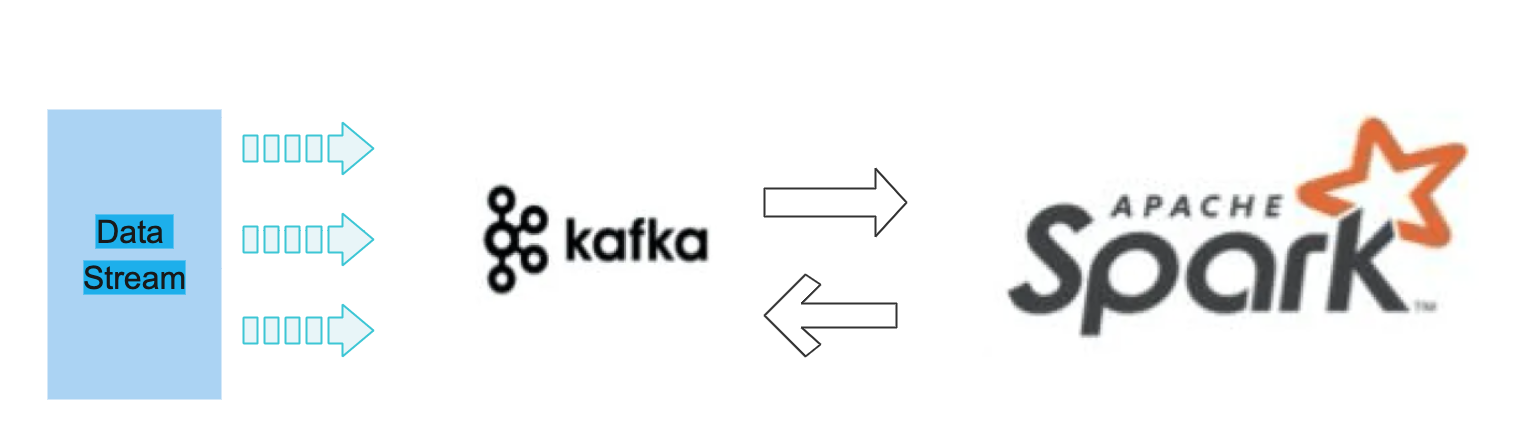

                                 Spark Streaming with Kafka

1. The streaming data is send to Kafka i.e producing messgaes to Kafka Topic. 
2. The messages from Kakfa topic are consumed in Spark via 'readStream()' configuration.
3. The Quote and reason is calculated based on Age and BMI Business Rules and additional 10% discount is given to Females.
4. The Spark Dataframe is then written to another Kafka Topic

### Kafka producer

1. Kafka Server is setup and bootstrap-server is localhost:9092
2. The data in the file is read and Kafka Producer publishes messages to Kafka Topic - 'bmi-quote-topic'

In [2]:
import csv, json
import logging
from json import dumps, loads
from kafka import KafkaProducer

# Create producer
producer = KafkaProducer(
    bootstrap_servers=['localhost:9092'], #Kafka server
    value_serializer=lambda v:json.dumps(v).encode('utf-8'),
    api_version=(0,10), request_timeout_ms=3600
    )

f = open('BMI.json',)
data = json.load(f)
try:
    for msg in data:
        try:
            producer.send('topic-BMI', msg)
        except ValueError:
            pass            
except KeyboardInterrupt:
    print("process interrupted")

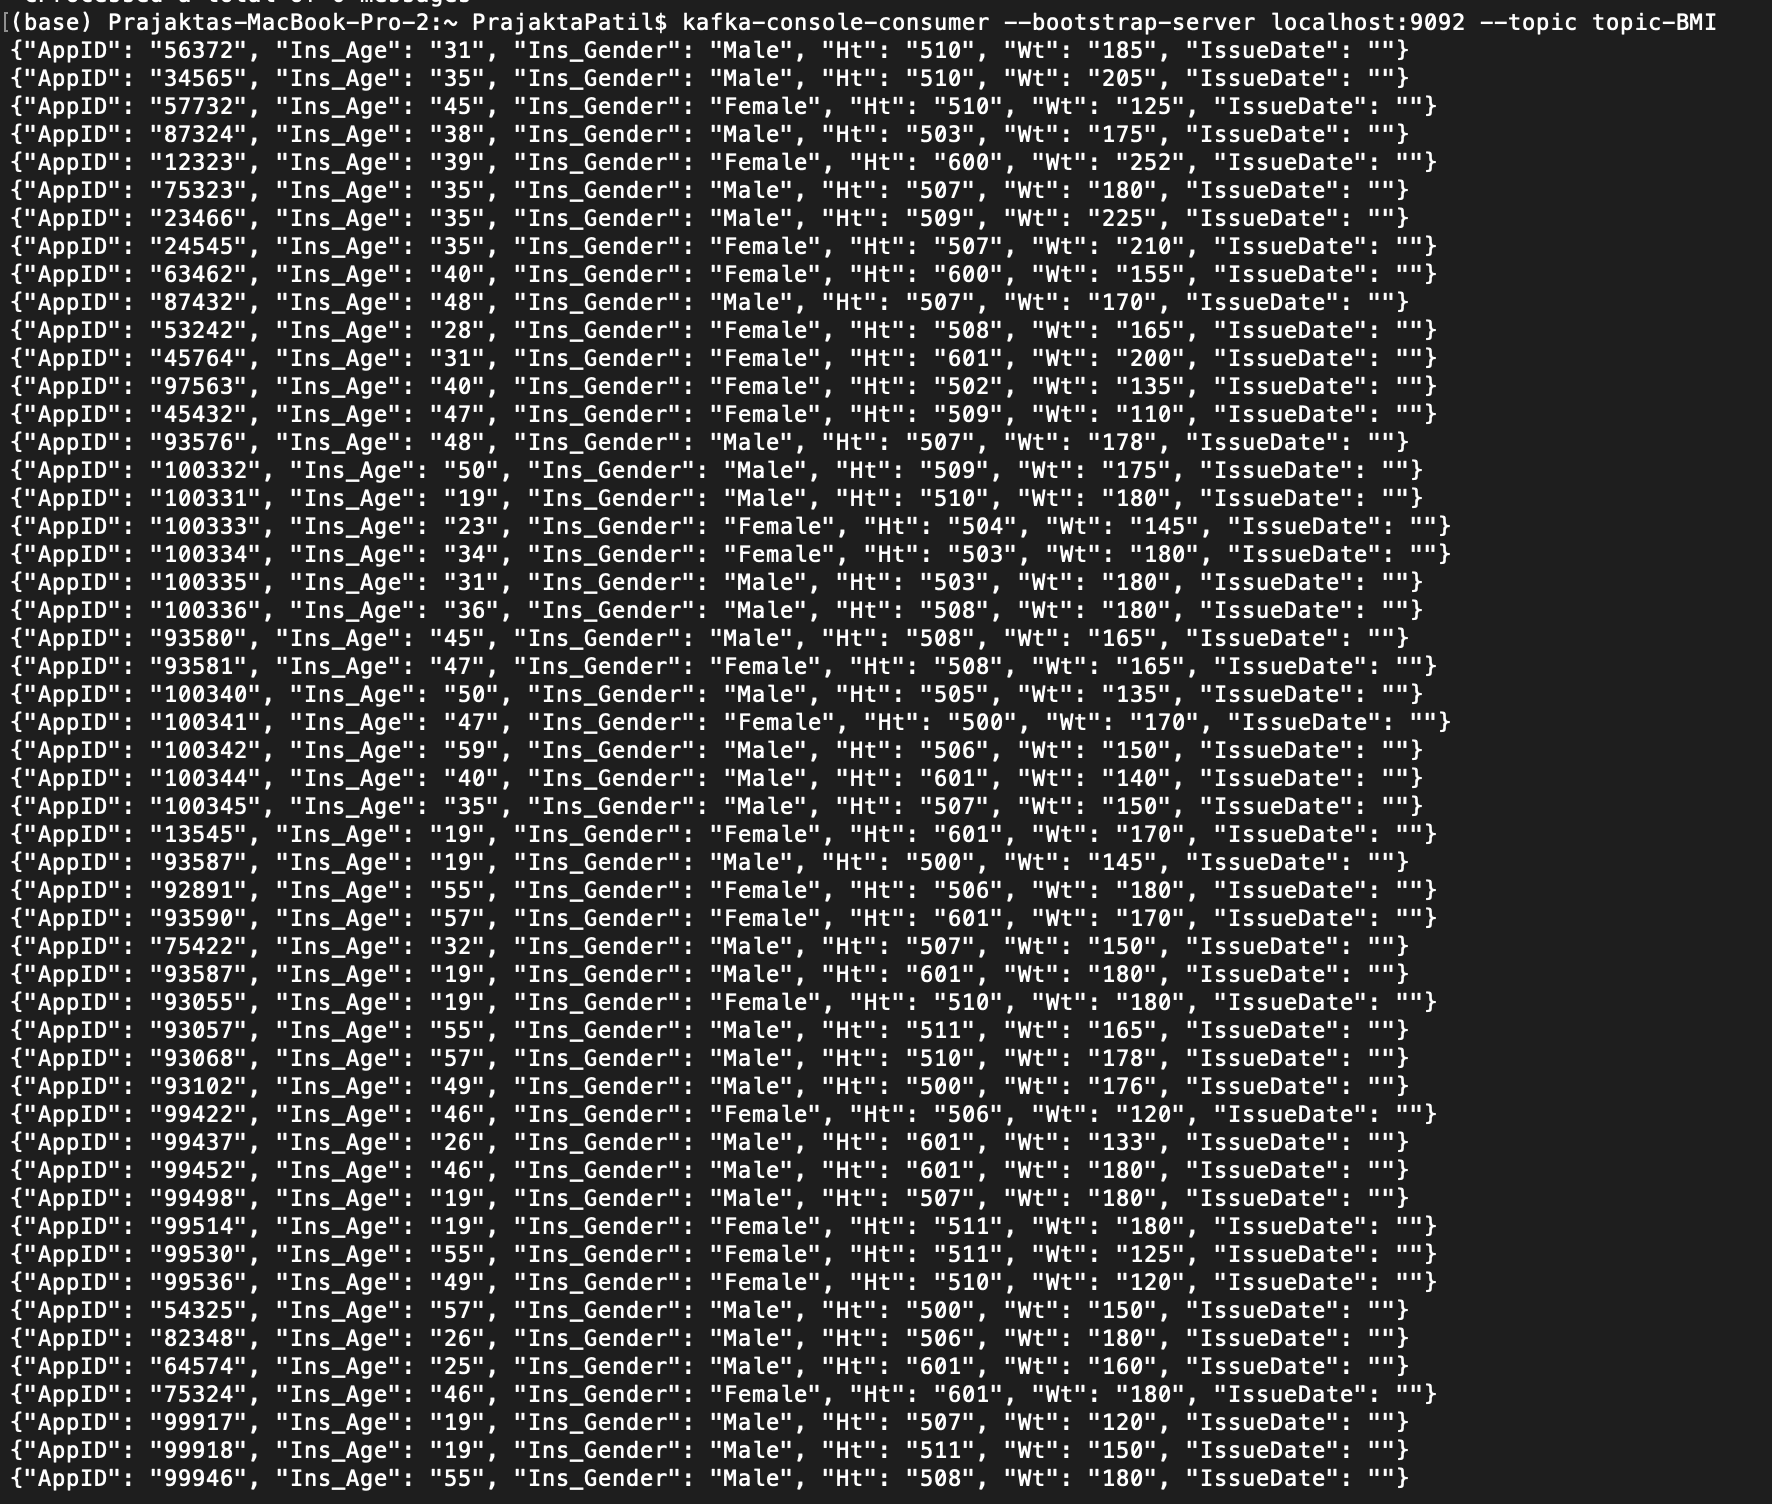

              Screenshot showing the input messages produced by the Kafka Producer to Topic 'topic-BMI'

### Spark Streaming 

1. Pyspark session is created using the pyspark sql's SparkSession
2. The messgaes from the Kafka topic are subscribed using the spark's readStream configuration

In [3]:
from pyspark.sql import SparkSession

# Spark session & context
spark = (SparkSession
         .builder
         .master('local')
         .appName('BMI-Consumer')
         # Add kafka package
         .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.5")
         .getOrCreate())
sc = spark.sparkContext

In [4]:
df = (spark
  .readStream
  .format("kafka")
  .option("kafka.bootstrap.servers", "localhost:9092") # kafka server
  .option("subscribe", "topic-BMI") # topic
  .option("startingOffsets", "earliest") # start from beginning 
  .load())

In [5]:
from pyspark.sql.types import *

# Convert binary to string key and value
df1 = (df
    .withColumn("key", df["key"].cast(StringType()))
    .withColumn("value", df["value"].cast(StringType())))

Defining Schema to be inferred

In [6]:
from pyspark.sql.functions import from_json
from pyspark.sql.types import *
bmi_schema = StructType(
    [StructField("AppID", StringType(), False),
     StructField("Ins_Age", StringType(), True),
     StructField("Ins_Gender", StringType(), True),
     StructField("Ht", StringType(), True),
     StructField("Wt", StringType(), True),
     StructField("IssueDate", StringType(), True)])

In [7]:
# Create dataframe setting schema for bmi data
df_new = (df1
           # Sets schema for bmi data
           .withColumn("value", from_json("value", bmi_schema))
          )

In [8]:
from pyspark.sql.functions import col, from_unixtime, to_date, to_timestamp

df_bmi = (df_new.select(
    col("key").alias("BMI_key"),
    col("topic").alias("BMI-topic"),
    col("timestamp").alias("BMI-msg-timestamp"),
    "value.AppID",
    "value.Ins_Age",
    "value.Ins_Gender",
    "value.Ht",
    "value.Wt",
    "value.IssueDate"))    

In [9]:
df_bmi = df_bmi.withColumn("Ht", df_bmi["Ht"].cast(DoubleType()))
df_bmi = df_bmi.withColumn("Wt", df_bmi["Wt"].cast(DoubleType()))
df_bmi = df_bmi.withColumn("Ins_Age", df_bmi["Ins_Age"].cast(IntegerType()))
df_bmi = df_bmi.withColumn("AppID", df_bmi["AppID"].cast(IntegerType()))
df_bmi = df_bmi.withColumn("IssueDate", df_bmi["IssueDate"].cast(DateType()))

In [10]:
df_bmi.printSchema()

root
 |-- BMI_key: string (nullable = true)
 |-- BMI-topic: string (nullable = true)
 |-- BMI-msg-timestamp: timestamp (nullable = true)
 |-- AppID: integer (nullable = true)
 |-- Ins_Age: integer (nullable = true)
 |-- Ins_Gender: string (nullable = true)
 |-- Ht: double (nullable = true)
 |-- Wt: double (nullable = true)
 |-- IssueDate: date (nullable = true)



## To Calculate the BMI value, creating a User Defined Function (UDF) in Pyspark

In [11]:
from pyspark.sql.functions import udf

In [12]:
def bmiCal(wt, ht):
    """
    Returns Body Mass Index (BMI) based on weight and height.
    Args - Weight in lbs
         - Height in feetInches
    Converts Weight in lbs to kgs and Height in FeetInches to meters and calculates BMI
    """
    
    wt_kgs = 0
    ht = ht / 100
    i, d = divmod(ht, 1)
    d = d * 100 
    ht_meters = (i * 0.3048) + (d * 0.0254)
    if wt:
        wt_kgs = (wt * 0.45359237)
    
    
    return (wt_kgs / (ht_meters * ht_meters ))

Applying the user defined function to the dataframe on columns 'Wt' and 'Ht'

In [14]:
udf_bmi = udf(bmiCal, StringType())

In [15]:
df_bmi = df_bmi.withColumn('BMI', udf_bmi(col("Wt"), col("Ht")))

In [16]:
df_bmi.printSchema()

root
 |-- BMI_key: string (nullable = true)
 |-- BMI-topic: string (nullable = true)
 |-- BMI-msg-timestamp: timestamp (nullable = true)
 |-- AppID: integer (nullable = true)
 |-- Ins_Age: integer (nullable = true)
 |-- Ins_Gender: string (nullable = true)
 |-- Ht: double (nullable = true)
 |-- Wt: double (nullable = true)
 |-- IssueDate: date (nullable = true)
 |-- BMI: string (nullable = true)



In [17]:
df_bmi = df_bmi.withColumn("BMI", df_bmi["BMI"].cast(DoubleType()))

In [18]:
#df_bmi.writeStream.format("console").outputMode("append").start()

## Calculating the quote in USD based on the Business Rules, along with the reason

1. Based on the age and BMI, quote is given along with the reason.
2. An additional 10% discount is given to Females on the quote value

In [19]:
def bmi(gender, age, bmi):
    """
    Returns quote and reason based on age and BMI.
    An addition 10% discount is given in quote for gender = Female
    
    Args - gender, age and bmi value
    """
    if (18 <= age <= 39) and (bmi < 17.49 or bmi > 38.5):
        quote = 750
        reason = 'Age is between 18 to 39 and BMI is either less than 17.49 or greater than 38.5'
    elif (40 <= age <= 59) and (bmi < 18.49 or bmi > 38.5):
        quote = 1000
        reason = 'Age is between 18 to 39 and BMI is either less than 18.49 or greater than 38.5'
    elif (age > 60) and (bmi < 18.49 or bmi > 45.5):
        quote = 2000
        reason = 'Age is greater than 60 and BMI is either less than 18.49 or greater than 45.5'
    else:
        quote = 500
        reason = 'BMI is in right range'
    
    if gender == 'Female':
        discount = quote/10
        return (quote - discount), reason
    else:
        return (quote), reason     

### Applying the bmi() UDF to get the quote and reason to the dataframe

In [20]:
print(bmi('Female', 61, 15))

(1800.0, 'Age is greater than 60 and BMI is either less than 18.49 or greater than 45.5')


In [21]:
schema = StructType([
    StructField("quote", StringType(), False),
    StructField("reason", StringType(), False)])

In [22]:
udf_quote = udf(bmi,schema)

In [23]:
df_bmi = df_bmi.withColumn('Quote', udf_quote(col("Ins_Gender"), col("Ins_Age"), col("BMI")))

In [24]:
df_bmi.writeStream.format("console").outputMode("append").start()

In [25]:
df_bmi.printSchema()

root
 |-- BMI_key: string (nullable = true)
 |-- BMI-topic: string (nullable = true)
 |-- BMI-msg-timestamp: timestamp (nullable = true)
 |-- AppID: integer (nullable = true)
 |-- Ins_Age: integer (nullable = true)
 |-- Ins_Gender: string (nullable = true)
 |-- Ht: double (nullable = true)
 |-- Wt: double (nullable = true)
 |-- IssueDate: date (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Quote: struct (nullable = true)
 |    |-- quote: string (nullable = false)
 |    |-- reason: string (nullable = false)



In [26]:
import pyspark.sql.functions as F
df_bmi_quote = df_bmi.select(col("AppID"), col("Ins_Age"), col("Ins_Gender"),col("Wt"), \
                             col("Ht"),col("IssueDate"),col("BMI"), \
                             F.col("Quote.quote").alias("quote"), \
                             F.col("Quote.reason").alias("reason"))

In [27]:
df_bmi_quote.writeStream.format("console").outputMode("append").start()

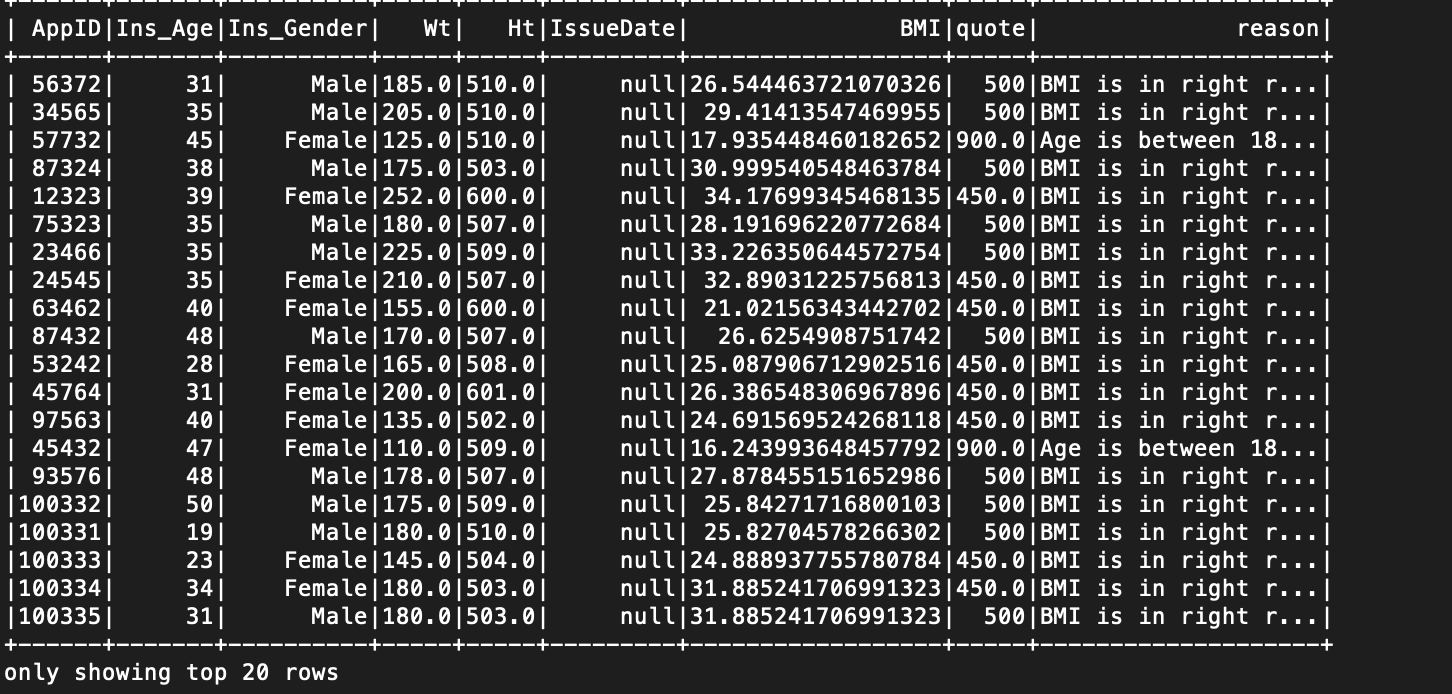

            Screenshot of the Dataframe with Quote and Reason based on age, BMI and gender

### Writing the results (quote and reason based on Age, BMI) to another Kafka Topic - 'bmi-quote-topic'

In [28]:
checkpoint_path = "Users/PrajaktaPatil/Downloads"
df_bmi_quote.selectExpr("CAST(AppID AS STRING) AS key", "to_json(struct(*)) AS value") \
   .writeStream \
   .format("kafka") \
   .outputMode("append") \
   .option("kafka.bootstrap.servers", "localhost:9092") \
   .option("checkpointLocation", "checkpoint_path")\
   .option("topic", "topic-BMI-with-quote") \
   .start()

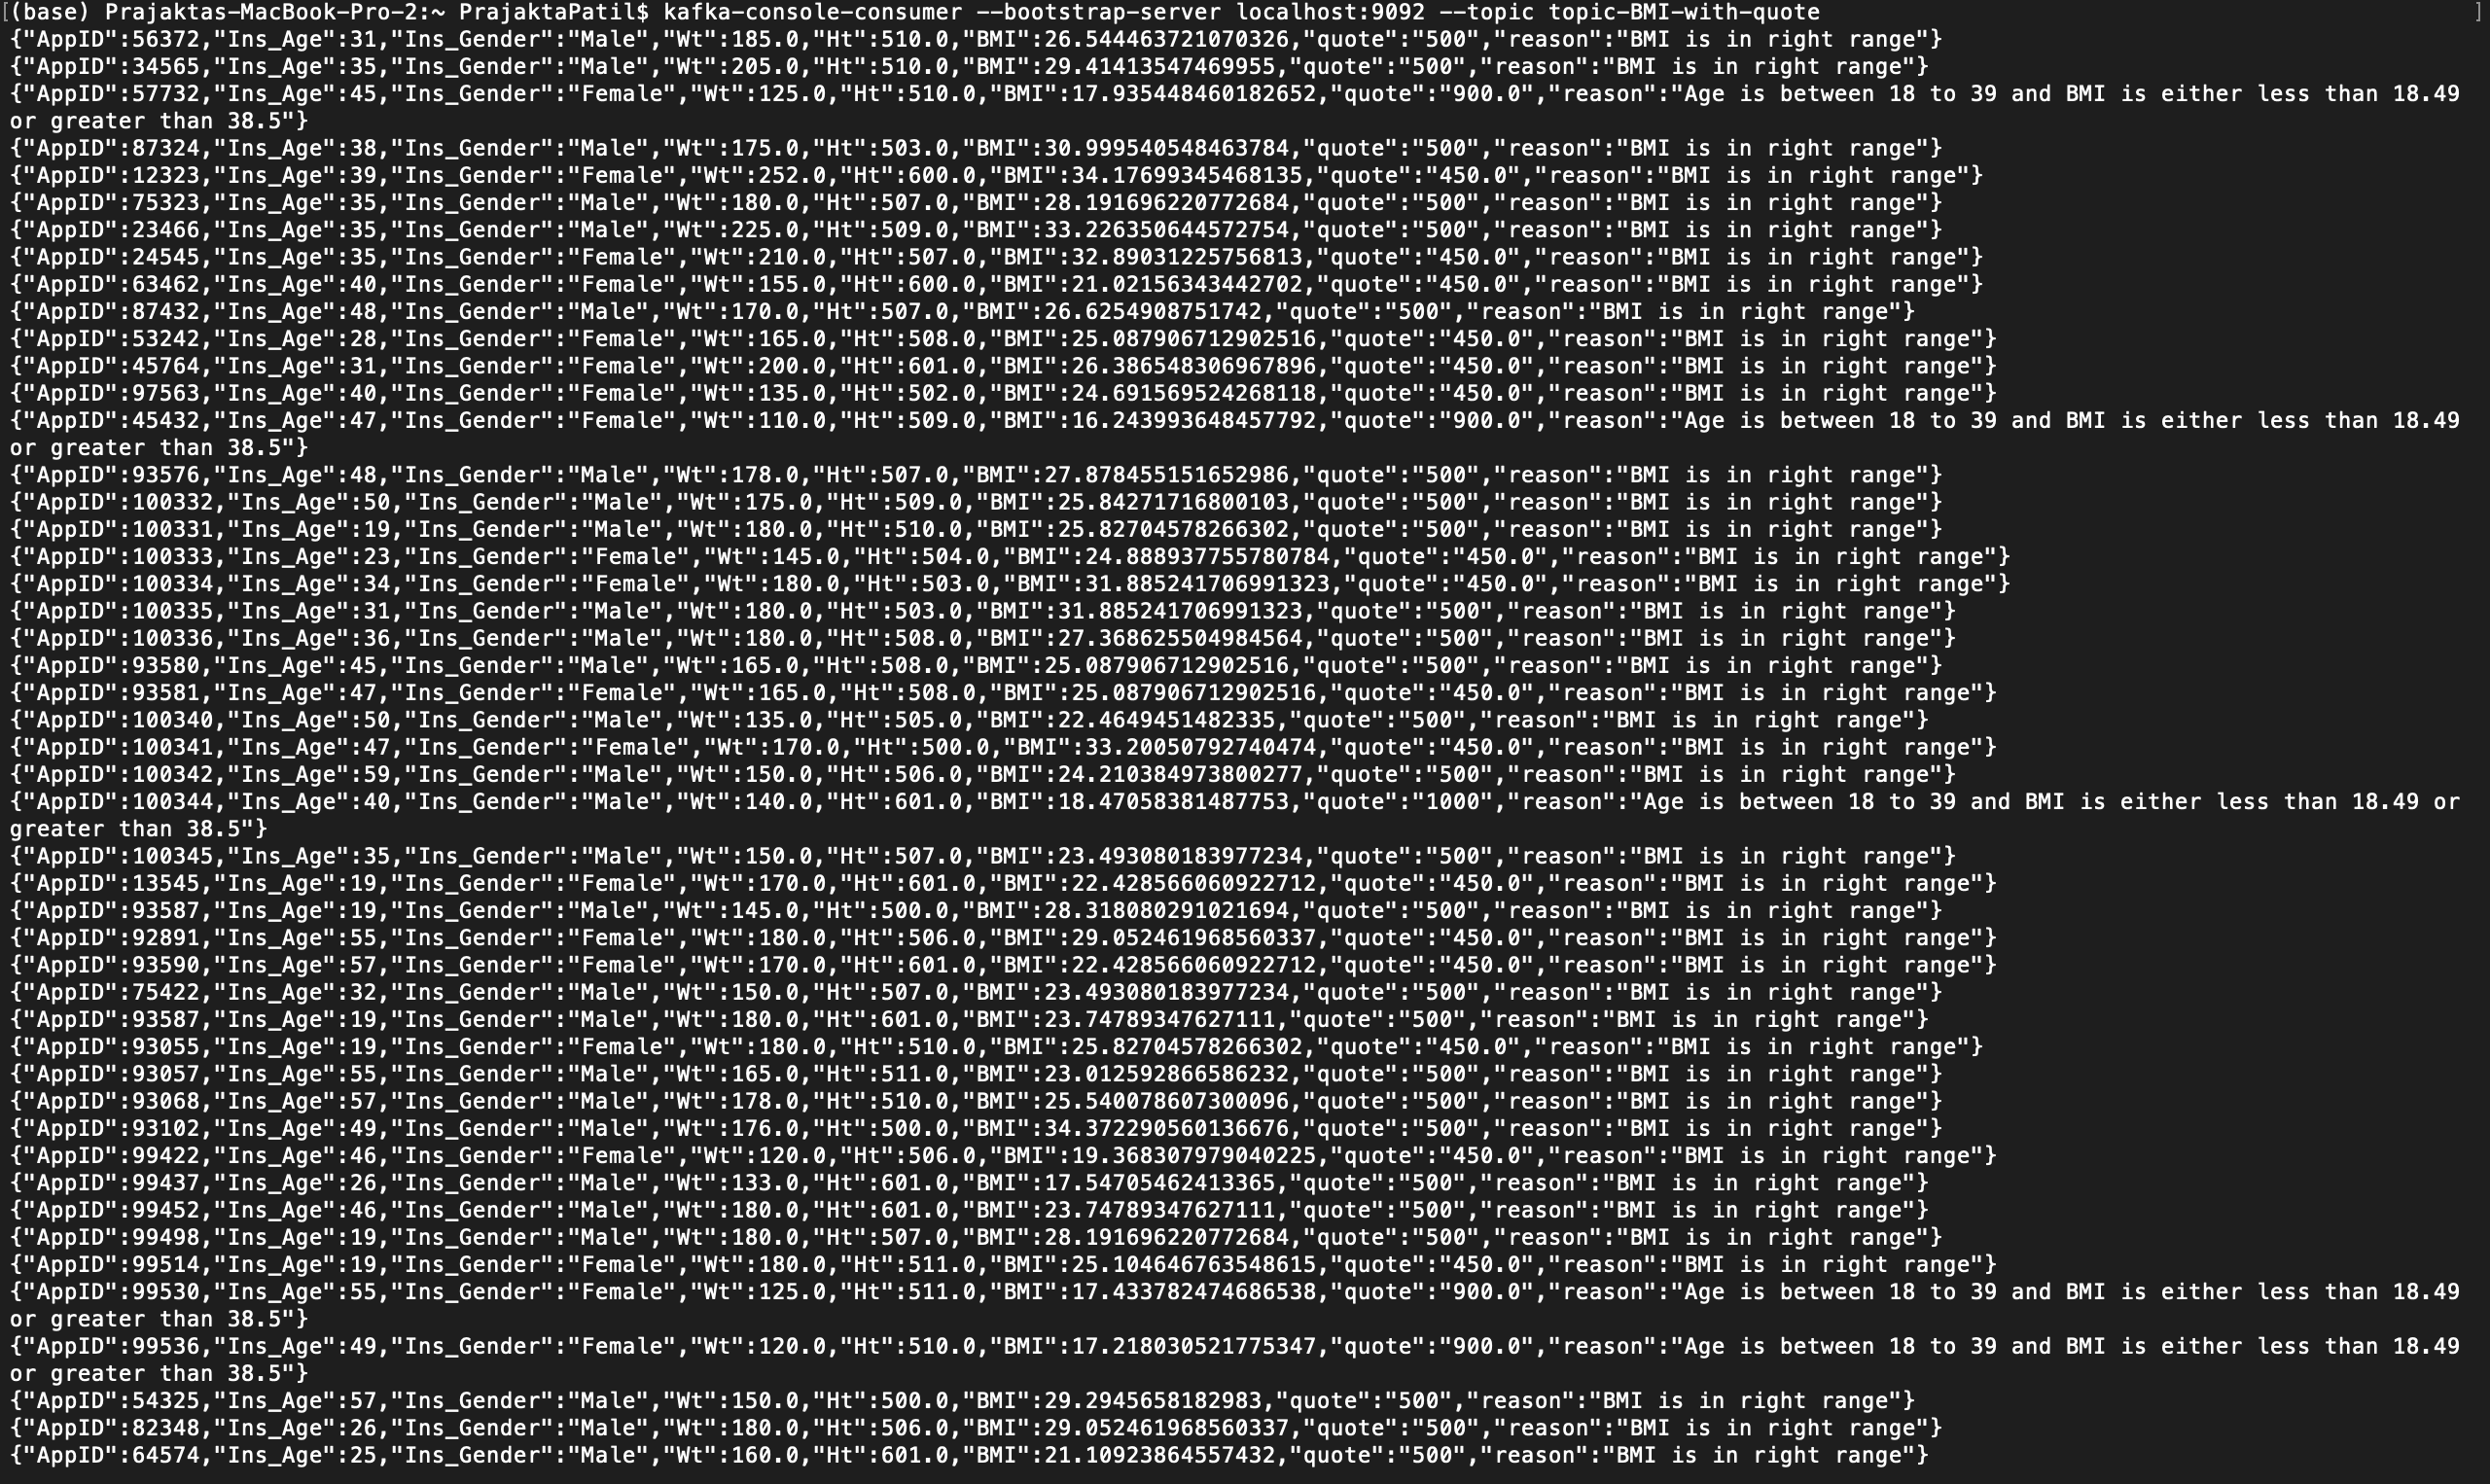

            Screenshot of the data being sent to another Kafka Topic 'topic-BMI-with-quote'